Choose an environment and configure it to continuous actions. Implement the algorithm of your choice, possibly using code from Lab sessions. Document the difference in behavior with your results on highway with discrete actions.

In [2]:
# Install environment and agent
!pip install highway-env
# TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
!pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.1 MB/s eta 0:00:00
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-hp8vkarv
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-hp8vkarv
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit 4af4a32d1b5acb06d585ef7bb0a00c83810fe5c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-

In [3]:
# Agent
from stable_baselines3 import DQN

# Visualization utils
%load_ext tensorboard
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 a

In [13]:
import gymnasium as gym

env = gym.make("highway-fast-v0", render_mode="rgb_array")

config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "ContinuousAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 20,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.2,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0.1,
    "reward_speed_range": [
        25,
        65,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 10,  # [Hz]
    "policy_frequency": 5,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}


env.unwrapped.configure(config)
print(env.reset()[1])

{'speed': 25, 'crashed': False, 'action': array([-0.869476  , -0.00990546], dtype=float32), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 1.0, 'high_speed_reward': 0.0, 'on_road_reward': 1.0}}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class ContinuousNet(nn.Module):
    def __init__(self, obs_size, hidden_size, action_dim):
        super(ContinuousNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
        )

    def forward(self, x):
        return self.net(x)

class ContinuousDQN:
    def __init__(self, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
      state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
      next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
      action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
      reward = torch.tensor([reward], dtype=torch.float32)
      terminated = torch.tensor([terminated], dtype=torch.float32)

      self.buffer.push(state, action, reward, terminated, next_state)

      if len(self.buffer) < self.batch_size:
          return np.inf

      transitions = self.buffer.sample(self.batch_size)
      batch = tuple(torch.cat(data) for data in zip(*transitions))

      state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = batch

      current_q_values = self.q_net(state_batch)
      next_q_values = self.target_net(next_state_batch)

      # Assuming each state-action pair produces a single scalar Q-value:
      current_q_values = current_q_values.sum(dim=1, keepdim=True)
      next_max_q_values = next_q_values.max(dim=1, keepdim=True)[0]

      targets = reward_batch + self.gamma * next_max_q_values * (1 - terminated_batch)

      loss = nn.MSELoss()(current_q_values, targets)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if self.n_steps % self.update_target_every == 0:
          self.target_net.load_state_dict(self.q_net.state_dict())

      self.decrease_epsilon()
      self.n_steps += 1

      return loss.item()

    def reset(self):
        obs_size = np.prod(self.observation_space.shape)
        action_dim = np.prod(self.action_space.shape)
        hidden_size = 128

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = ContinuousNet(obs_size, hidden_size, action_dim)
        self.target_net = ContinuousNet(obs_size, hidden_size, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

    def get_action(self, state, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon

        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension

        if np.random.rand() < epsilon:
            return self.action_space.sample()  # This samples a continuous action directly from the space
        else:
            q_values = self.q_net(state)  # Predict continuous actions
            return q_values.detach().numpy().flatten()  # Convert actions back to numpy array

    def decrease_epsilon(self):
        # Decrease epsilon linearly or exponentially based on some factor
        self.epsilon = max(self.epsilon_min, self.epsilon - self.decrease_epsilon_factor)



In [22]:
import numpy as np
from copy import deepcopy

def eval_agent(agent, env, n_sim=5):
    """
    Monte Carlo evaluation of a DQN-like agent adapted for continuous action spaces.

    Repeat n_sim times:
        * Run the agent's policy until the environment reaches a terminal state (= one episode).
        * Compute the sum of rewards in this episode.
        * Store the sum of rewards in the episode_rewards array.
    """
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env.reset()  # Reset the environment to start a new episode
        state = state.flatten()  # Flattening the state to match the expected input dimension for the agent
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)  # Use epsilon=0 to exploit the best known strategy
            state, reward, terminated, truncated, _ = env.step(action)
            state = state.flatten()  # Ensure the state is flattened after each environment step
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


Episode = 10 , Average Reward =  11.596110600309501
Episode = 20 , Average Reward =  13.95017955937596
Episode = 30 , Average Reward =  10.521729803871123
Episode = 40 , Average Reward =  4.700038961759625
Episode = 50 , Average Reward =  9.290811826818128
Episode = 60 , Average Reward =  11.791024411266424
Episode = 70 , Average Reward =  8.628387054138381
Episode = 80 , Average Reward =  8.786283836227526
Episode = 90 , Average Reward =  10.800132862280822
Episode = 100 , Average Reward =  13.313348670030885
Episode = 110 , Average Reward =  9.849125452030787
Episode = 120 , Average Reward =  4.700038828842194
Episode = 130 , Average Reward =  5.841699509527867
Episode = 140 , Average Reward =  7.7104162764258914
Episode = 150 , Average Reward =  11.653941847475798
Episode = 160 , Average Reward =  12.262725450334326
Episode = 170 , Average Reward =  12.685789652576096
Episode = 180 , Average Reward =  10.717839315077594
Episode = 190 , Average Reward =  10.717087206842809
Episode = 

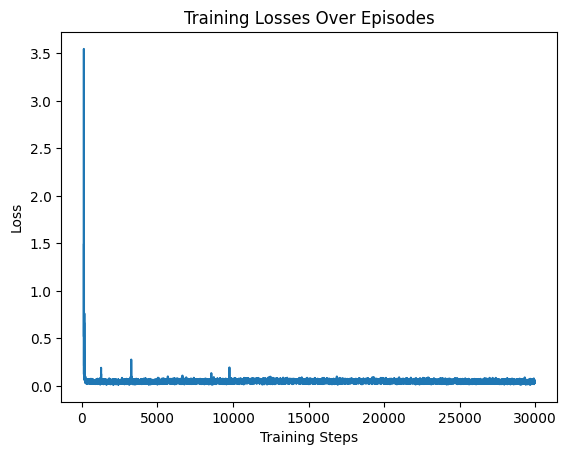


Mean reward after training =  10.73575024981449


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming the agent and environment are correctly initialized and configured
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.99
batch_size = 128
buffer_capacity = 10_000
update_target_every = 32

epsilon_start = 0.9
decrease_epsilon_factor = 1000
epsilon_min = 0.05

learning_rate = 1e-1

arguments = (action_space,
            observation_space,
            gamma,
            batch_size,
            buffer_capacity,
            update_target_every,
            epsilon_start,
            decrease_epsilon_factor,
            epsilon_min,
            learning_rate,
        )

N_episodes = 300

agent = ContinuousDQN(*arguments)

def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    state = state.flatten().astype(np.float32)  # Ensure state is ready for the network
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        state = state.flatten().astype(np.float32)  # Flattening and converting the state at reset for each episode
        while not done:
            action = agent.get_action(state, agent.epsilon)  # Ensure action is calculated with current epsilon

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = next_state.flatten().astype(np.float32)  # Preparing next state
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if ((ep+1) % eval_every == 0):
            rewards = eval_agent(agent, env, 5)  # Evaluate the agent periodically
            print("Episode =", ep+1, ", Average Reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                print("Reward threshold met, stopping training.")
                break

    return losses

# Run the training loop
losses = train(env, agent, N_episodes)

plt.plot(losses)
plt.title("Training Losses Over Episodes")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("\nMean reward after training = ", np.mean(rewards))


In [35]:
#env = gym.make('highway-fast-v0', render_mode='rgb_array')
env = record_videos(env)  # Assuming this is a valid function to record videos

# Perform testing on the environment
for episode in trange(1, desc='Test episodes'):  # Adjust the range if you want more episodes
    obs, info = env.reset()
    obs = obs.flatten()  # Flatten the observation to match the agent's expected input format
    done = False
    i = 0
    while not done and i < 1000:
        action = agent.get_action(obs, 0)  # Using 0 for epsilon to always choose the best action (no exploration)
        obs, reward, done, truncated, info = env.step(action)  # No need to cast action to int
        obs = obs.flatten()  # Flatten the observation after each step
        i += 1

env.close()  # Make sure to close the environment when done

NameError: name 'record_videos' is not defined

In [ ]:
show_videos()